In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe
from matplotlib.ticker import FormatStrFormatter

import corner

import result_utils
import os; print(os.environ['LD_LIBRARY_PATH'])

/net/lem/data2/regt/MultiNest/lib:/software/rhel9-amd/lib64:


In [2]:
name_A = 'Luhman 16A'; name_B = 'Luhman 16B'
color_A = '#FF622E'; color_B = '#396ED8'

cmap_A = mpl.colors.LinearSegmentedColormap.from_list('', ['w',color_A])
env_colors_A = cmap_A([0,1/4,2/4,3/4,1])
env_colors_A[:,3] = 0.5; env_colors_A[0,3] = 0.0

cmap_B = mpl.colors.LinearSegmentedColormap.from_list('', ['w',color_B])
env_colors_B = cmap_B([0,1/4,2/4,3/4,1])
env_colors_B[:,3] = 0.5; env_colors_B[0,3] = 0.0

lw_d = 0.8
lw_m = 1.0

res_alpha = 0.85

path = '/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs'
A = result_utils.RetrievalResults(f'{path}/freechem_K_A_ret_6/test_')
B = result_utils.RetrievalResults(f'{path}/freechem_K_B_ret_6/test_')
A_eq = result_utils.RetrievalResults(f'{path}/eqchem_K_A_ret_3/test_')
B_eq = result_utils.RetrievalResults(f'{path}/eqchem_K_B_ret_4/test_')

/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_A_ret_6/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_A_ret_6/test_.txt
/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_B_ret_6/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/freechem_K_B_ret_6/test_.txt
/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/eqchem_K_A_ret_3/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/eqchem_K_A_ret_3/test_.txt
/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/eqchem_K_B_ret_4/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/eqchem_K_B_ret_4/test_.txt


In [3]:
def get_chemical_ratios(Res, mean_along_axis=None, P=0.4):
    
    # Load the chemistry module
    Res.load_components(['Chem'])

    m_set = Res.model_settings[0]
    VMRs = Res.Chem[m_set].VMRs_posterior

    posterior_shape = (Res.posterior.shape[0], len(Res.Chem[m_set].pressure))

    chem_ratios = {}
    chem_ratios['C/O'] = (
        (VMRs.get('12CO',0.)+VMRs.get('CH4',0.)+VMRs.get('13CO',0.)) / 
        (VMRs.get('12CO',0.)+VMRs.get('13CO',0.)+VMRs.get('H2O',0.))
    )

    # Isotope ratios
    chem_ratios['12CO/13CO'] = VMRs.get('12CO',0.) / VMRs.get('13CO',np.inf)
    chem_ratios['C16O/C18O'] = VMRs.get('12CO',0.) / VMRs.get('C18O',np.inf)
    chem_ratios['C16O/C17O'] = VMRs.get('12CO',0.) / VMRs.get('C17O',np.inf)
    
    chem_ratios['H2O/HDO'] = VMRs.get('H2O',0.) / VMRs.get('HDO',np.inf)
    chem_ratios['H2(16)O/H2(18)O'] = VMRs.get('H2O',0.) / VMRs.get('H2(18)O',np.inf)
    chem_ratios['H2(16)O/H2(17)O'] = VMRs.get('H2O',0.) / VMRs.get('H2(17)O',np.inf)

    chem_ratios['12CH4/13CH4'] = VMRs.get('CH4',0.) / VMRs.get('13CH4',np.inf)
    chem_ratios['14NH3/15NH3'] = VMRs.get('NH3',0.) / VMRs.get('15NH3',np.inf)
    
    # Absolute abundances
    abs_abund = {}
    solar = {
        'C':10**8.46, 'N':10**7.83, 'O':10**8.69, 'F':10**4.40, 'S':10**7.12, 'H':10**12.0, 
        'Na': 10**6.22, 'K': 10**5.07, 'Fe': 10**7.46, 
        }

    VMR_H = (
        VMRs.get('H2',0.)*2 + VMRs.get('H2O',0.)*2 + VMRs.get('CH4',0.)*4 + \
        VMRs.get('NH3',0.)*3 + VMRs.get('H2S',0.)*2 + VMRs.get('HF',0.)*1 + \
        VMRs.get('FeH',0.)*1 
    )
    VMR_C = VMRs.get('12CO',0.) + VMRs.get('CH4',0.) + VMRs.get('13CO',0.)
    VMR_N = VMRs.get('NH3',0.)
    VMR_O = VMRs.get('H2O',0.) + VMRs.get('12CO',0.) + VMRs.get('13CO',0.)
    VMR_F = VMRs.get('HF',0.)
    VMR_S = VMRs.get('H2S',0.)
    
    VMR_Na = VMRs.get('Na',0.)
    VMR_K = VMRs.get('K',0.)
    VMR_Fe = VMRs.get('Fe',0.) + VMRs.get('FeH',0.)

    abs_abund['C/H'] = np.log10(VMR_C/VMR_H) - np.log10(solar['C']/solar['H'])
    abs_abund['N/H'] = np.log10(VMR_N/VMR_H) - np.log10(solar['N']/solar['H'])
    abs_abund['O/H'] = np.log10(VMR_O/VMR_H) - np.log10(solar['O']/solar['H'])
    abs_abund['F/H'] = np.log10(VMR_F/VMR_H) - np.log10(solar['F']/solar['H'])
    abs_abund['S/H'] = np.log10(VMR_S/VMR_H) - np.log10(solar['S']/solar['H'])
    abs_abund['Na/H'] = np.log10(VMR_Na/VMR_H) - np.log10(solar['Na']/solar['H'])
    abs_abund['K/H'] = np.log10(VMR_K/VMR_H) - np.log10(solar['K']/solar['H'])
    abs_abund['Fe/H'] = np.log10(VMR_Fe/VMR_H) - np.log10(solar['Fe']/solar['H'])

    abs_abund['(C+O)/H'] = (
        np.log10((VMR_C+VMR_O)/VMR_H) - np.log10((solar['C']+solar['O'])/solar['H'])
    )
    abs_abund['M/H'] = (
        np.log10((VMR_C+VMR_N+VMR_O+VMR_F+VMR_S+VMR_Na+VMR_K+VMR_Fe)/VMR_H) - \
        np.log10((
            solar['C']+solar['N']+solar['O']+solar['F']+solar['S']+solar['Na']+solar['K']+solar['Fe']
            )/solar['H'])
    )
            
    if mean_along_axis is not None:

        idx_P = np.argmin(np.abs(Res.Chem[m_set].pressure-P))
        keys = list(chem_ratios.keys())

        for key in keys:
            if isinstance(chem_ratios[key], float):
                chem_ratios[key] = np.ones(posterior_shape) * chem_ratios[key]

            #chem_ratios[key] = np.mean(chem_ratios[key], axis=mean_along_axis)
            chem_ratios[key] = chem_ratios[key][:,idx_P]

            # For chemical equilibrium retrievals
            idx = Res.ParamTable.get(key, key='idx_free')
            if idx is not None:
                print(idx, key)
                chem_ratios[f'{key}_mean'] = chem_ratios[key].copy()
                chem_ratios[key] = Res.posterior[:,idx]
            
            idx = Res.ParamTable.get(f'log_{key.split("/")[-1]}_ratio', key='idx_free')
            if idx is not None:
                print(idx, 'log_'+key)
                chem_ratios[f'{key}_mean'] = chem_ratios[key].copy()
                chem_ratios[key] = 10**Res.posterior[:,idx]

        for key in abs_abund.keys():
            if isinstance(abs_abund[key], float):
                abs_abund[key] = np.ones(posterior_shape) * abs_abund[key]

            #abs_abund[key] = np.mean(abs_abund[key], axis=mean_along_axis)
            abs_abund[key] = abs_abund[key][:,idx_P]

        for key, VMR in VMRs.items():
            abs_abund[key] = VMR[:,idx_P]

    return chem_ratios, abs_abund

chem_ratios_A, abs_abund_A = get_chemical_ratios(A, mean_along_axis=-1)
chem_ratios_B, abs_abund_B = get_chemical_ratios(B, mean_along_axis=-1)

chem_ratios_A_eq, abs_abund_A_eq = get_chemical_ratios(A_eq, mean_along_axis=-1)
chem_ratios_B_eq, abs_abund_B_eq = get_chemical_ratios(B_eq, mean_along_axis=-1)

/var/tmp/regt/ipykernel_533962/3511495184.py:56: RuntimeWarning: divide by zero encountered in log10
  abs_abund['Na/H'] = np.log10(VMR_Na/VMR_H) - np.log10(solar['Na']/solar['H'])
/var/tmp/regt/ipykernel_533962/3511495184.py:57: RuntimeWarning: divide by zero encountered in log10
  abs_abund['K/H'] = np.log10(VMR_K/VMR_H) - np.log10(solar['K']/solar['H'])
/var/tmp/regt/ipykernel_533962/3511495184.py:58: RuntimeWarning: divide by zero encountered in log10
  abs_abund['Fe/H'] = np.log10(VMR_Fe/VMR_H) - np.log10(solar['Fe']/solar['H'])


8 C/O
11 log_12CO/13CO
12 log_C16O/C18O
13 log_C16O/C17O
14 log_H2(16)O/H2(18)O
15 log_H2(16)O/H2(17)O
8 C/O
11 log_12CO/13CO
12 log_C16O/C18O
13 log_C16O/C17O
14 log_H2(16)O/H2(18)O
15 log_H2(16)O/H2(17)O


In [4]:
A_J = result_utils.RetrievalResults(f'{path}/J_A_ret_22_1column_n1000/test_')
B_J = result_utils.RetrievalResults(f'{path}/J_B_ret_62_1column_n1000/test_')

A_J.model_settings = ['J1226_1']; B_J.model_settings = ['J1226_1']

A_J.load_components(['Chem'])
B_J.load_components(['Chem'])

chem_ratios_A_J, abs_abund_A_J = get_chemical_ratios(A_J, mean_along_axis=-1, P=10**(np.log10(9.)-0.2))
print(np.median(abs_abund_A_J['FeH']))
chem_ratios_B_J, abs_abund_B_J = get_chemical_ratios(B_J, mean_along_axis=-1, P=10**(np.log10(9.)+0.2))

/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/J_A_ret_22_1column_n1000/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/J_A_ret_22_1column_n1000/test_.txt
/net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/J_B_ret_62_1column_n1000/test_data
  analysing data from /net/schenk/data2/regt/data_backup/Luhman_16/retrieval_outputs/J_B_ret_62_1column_n1000/test_.txt
7.024229990418659e-09


/var/tmp/regt/ipykernel_533962/3511495184.py:51: RuntimeWarning: divide by zero encountered in log10
  abs_abund['C/H'] = np.log10(VMR_C/VMR_H) - np.log10(solar['C']/solar['H'])
/var/tmp/regt/ipykernel_533962/3511495184.py:52: RuntimeWarning: divide by zero encountered in log10
  abs_abund['N/H'] = np.log10(VMR_N/VMR_H) - np.log10(solar['N']/solar['H'])
/var/tmp/regt/ipykernel_533962/3511495184.py:55: RuntimeWarning: divide by zero encountered in log10
  abs_abund['S/H'] = np.log10(VMR_S/VMR_H) - np.log10(solar['S']/solar['H'])


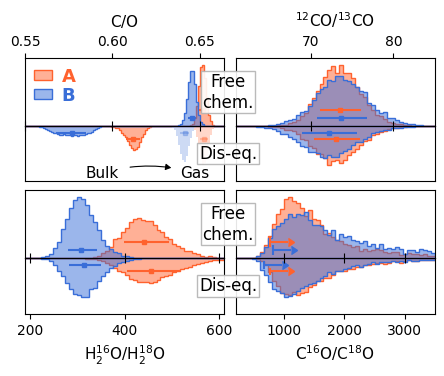

In [5]:
def plot_errorbar(ax, posterior, y, q, transform=None, ms=3.5, **kwargs):

    x = np.median(posterior)
    xerr = np.quantile(posterior, q=q) - x
    xerr = np.abs(xerr)[:,None]

    if transform is None:
        transform = ax.get_xaxis_transform()

    if xerr.shape[0] == 1:
        ax.errorbar(
            x-xerr, y, yerr=0.07, transform=transform, fmt='', lw=1.5, ms=ms, capsize=0, xlolims=True, **kwargs,
            )
    else:
        ax.errorbar(
            x, y, xerr=xerr, transform=transform, fmt='s', lw=1.5, ms=ms, capsize=0, **kwargs,
            )

hist_kwargs_A = dict(
    #bins=25, histtype='stepfilled', fc=env_colors_m_A[1], ec=color_m_A, lw=2, bottom=0, density=True
    histtype='stepfilled', fc=env_colors_A[-1], ec=color_A, lw=lw_m, bottom=0, density=True
)

hist_kwargs_B = hist_kwargs_A.copy()
hist_kwargs_B['fc'] = env_colors_B[-1]
hist_kwargs_B['ec'] = color_B

hist_kwargs_A_eq = hist_kwargs_A.copy()
# hist_kwargs_A_eq['fc'] = env_colors_A[2]
# hist_kwargs_A_eq['hatch'] = '\\\\'

hist_kwargs_B_eq = hist_kwargs_B.copy()
# hist_kwargs_B_eq['fc'] = env_colors_B[2]
# hist_kwargs_B_eq['hatch'] = '//'

hist_kwargs_gas = hist_kwargs_A.copy()
hist_kwargs_gas.pop('fc', None)
hist_kwargs_gas['ec'] = 'none'
# hist_kwargs_gas['lw'] = 0.8

hist_info = {
    'C/O':             (100, [0.550, 0.664]), 
    '12CO/13CO':       (50, [61,85]), 
    'H2(16)O/H2(18)O': (50, [190,610]), 
    'C16O/C18O':       (50, [200,3500]), 
}

fig = plt.figure(figsize=(4.5,3.7))
gs = fig.add_gridspec(
    # nrows=5, ncols=2, hspace=0., wspace=0.08, height_ratios=[1,1,0.2,1,1],
    nrows=5, ncols=2, hspace=0., wspace=0.06, height_ratios=[1.1,0.9,0.15,1.1,0.9],
)
ax_1 = [fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1])]
ax_2 = [fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1])]
ax_2 += [fig.add_subplot(gs[4,0]), fig.add_subplot(gs[4,1])]
ax_1 += [fig.add_subplot(gs[3,0]), fig.add_subplot(gs[3,1])]
ax_1 = np.array(ax_1)
ax_2 = np.array(ax_2)

for i, key in enumerate(hist_info.keys()):
    bins, hist_range = hist_info[key]

    handle_A = ax_1[i].hist(chem_ratios_A[key], label='A', bins=bins, range=hist_range, **hist_kwargs_A)
    handle_B = ax_1[i].hist(chem_ratios_B[key], label='B', bins=bins, range=hist_range, **hist_kwargs_B)
    ax_2[i].hist(chem_ratios_A_eq[key], bins=bins, range=hist_range, **hist_kwargs_A_eq)
    ax_2[i].hist(chem_ratios_B_eq[key], bins=bins, range=hist_range, **hist_kwargs_B_eq)

    if key == 'C/O':
        ax_2[i].hist(chem_ratios_A_eq[f'{key}_mean'], bins=bins, range=hist_range, fc=env_colors_A[2], **hist_kwargs_gas)
        ax_2[i].hist(chem_ratios_B_eq[f'{key}_mean'], bins=bins, range=hist_range, fc=env_colors_B[2], **hist_kwargs_gas)
        plot_errorbar(ax_2[i], chem_ratios_A_eq[f'{key}_mean'], y=0.76, q=result_utils.q[[2,4]], color=color_A, alpha=0.3)
        plot_errorbar(ax_2[i], chem_ratios_B_eq[f'{key}_mean'], y=0.88, q=result_utils.q[[2,4]], color=color_B, alpha=0.3)

    if key != 'C16O/C18O':
        plot_errorbar(ax_1[i], chem_ratios_A[key], y=0.24, q=result_utils.q[[2,4]], color=color_A)
        plot_errorbar(ax_1[i], chem_ratios_B[key], y=0.12, q=result_utils.q[[2,4]], color=color_B)
        plot_errorbar(ax_2[i], chem_ratios_A_eq[key], y=0.76, q=result_utils.q[[2,4]], color=color_A)
        plot_errorbar(ax_2[i], chem_ratios_B_eq[key], y=0.88, q=result_utils.q[[2,4]], color=color_B)
    else:
        plot_errorbar(ax_1[i], chem_ratios_A[key], y=0.24, q=result_utils.q[[1]], color=color_A, xerr=300)
        plot_errorbar(ax_1[i], chem_ratios_B[key], y=0.12, q=result_utils.q[[1]], color=color_B, xerr=300)
        plot_errorbar(ax_2[i], chem_ratios_A_eq[key], y=0.76, q=result_utils.q[[1]], color=color_A, xerr=300)
        plot_errorbar(ax_2[i], chem_ratios_B_eq[key], y=0.88, q=result_utils.q[[1]], color=color_B, xerr=300)


    ylim = ax_1[i].get_ylim()
    ylim = [ylim[0], ylim[1]*1.05]
    ax_1[i].set(xlim=hist_range, yticks=[], ylim=ylim, facecolor='none')

    ylim = ax_2[i].get_ylim()
    ylim = [ylim[0], ylim[1]*1.35]
    ax_2[i].set(xlim=hist_range, yticks=[], ylim=ylim, facecolor='none')
    ax_2[i].yaxis.set_inverted(True)

ax_1[0].tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False)
ax_1[1].tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False)
ax_2[0].tick_params(axis='x', top=True, labeltop=False, bottom=False, labelbottom=False, direction='inout', length=7)
ax_2[1].tick_params(axis='x', top=True, labeltop=False, bottom=False, labelbottom=False, direction='inout', length=7)

ax_1[2].tick_params(axis='x', labelbottom=False, direction='inout', length=7)
ax_1[3].tick_params(axis='x', labelbottom=False, direction='inout', length=7)

ax_1[0].set_xlabel(r'$\mathrm{C/O}$', fontsize=11, labelpad=6.0)
ax_1[1].set_xlabel(r'$\mathrm{^{12}CO/^{13}CO}$', fontsize=11, labelpad=6.0)
ax_2[2].set_xlabel(r'$\mathrm{H_2^{16}O/H_2^{18}O}$', fontsize=11)
ax_2[3].set_xlabel(r'$\mathrm{C^{16}O/C^{18}O}$', fontsize=11)

ax_1[0].xaxis.set_label_position('top')
ax_1[1].xaxis.set_label_position('top')

ann_kwargs = dict(
    xycoords='axes fraction', ha='center', va='center', fontsize=12, 
    bbox={'boxstyle':'square,pad=0.1', 'ec':'0.7', 'fc':'w', 'alpha':0.9}, 
)
for i in [1,3]:
    ax_1[i].annotate('Free\nchem.', xy=(-0.04,0.5), **ann_kwargs)
    ax_2[i].annotate('Dis-eq.', xy=(-0.04,0.5), **ann_kwargs)

ann_kwargs = dict(xycoords=ax_2[0].get_xaxis_transform(), ha='center', va='center', fontsize=11)

xy = (np.mean([np.median(chem_ratios_A_eq['C/O_mean']),np.median(chem_ratios_B_eq['C/O_mean'])]),0.15)
ax_2[0].annotate('Gas', xy=xy, **ann_kwargs)
xytext = (np.mean([np.median(chem_ratios_A_eq['C/O']),np.median(chem_ratios_B_eq['C/O'])]),0.15)
ax_2[0].annotate(
    'Bulk', xy=xy, xytext=xytext, **ann_kwargs, arrowprops=dict(
        arrowstyle='-|>,head_width=0.17,head_length=0.3', shrinkB=17, shrinkA=6, 
        connectionstyle='arc3,rad=-0.15', lw=0.8, color='k'
        )
    )

ax_1[0].legend(
    loc='upper left', bbox_to_anchor=(0.,1.), labelspacing=0.05, handlelength=1.0, handleheight=0.5, 
    handletextpad=0.5, borderpad=0., labelcolor=[color_A, color_B], prop={'weight':'bold', 'size':13}, frameon=False, 
)

plt.subplots_adjust(left=0.05, bottom=0.16, top=0.85, right=0.96)
plt.savefig(f'./plots/K_band_chem_ratios.pdf')
plt.show()

In [6]:
result_utils.latex_format(chem_ratios_A_eq['C/O'], chem_ratios_B_eq['C/O'], decimals=3)

$0.612^{+0.004}_{-0.004}$ & $0.576^{+0.009}_{-0.009}$ \\


In [7]:
result_utils.latex_format(chem_ratios_A['C/O'], chem_ratios_B['C/O'], decimals=3)
result_utils.latex_format(chem_ratios_A['12CO/13CO'], chem_ratios_B['12CO/13CO'], decimals=0)
# result_utils.latex_format(chem_ratios_A['C16O/C18O'], chem_ratios_B['C16O/C18O'], q=result_utils.q[[4,2]], decimals=0)
result_utils.latex_format(chem_ratios_A['C16O/C18O'], chem_ratios_B['C16O/C18O'], q=result_utils.q[1], decimals=0)
# result_utils.latex_format(chem_ratios_A['C16O/C18O'], chem_ratios_B['C16O/C18O'], q=result_utils.q[0], decimals=0)
# result_utils.latex_format(chem_ratios_A['C16O/C18O'], chem_ratios_B['C16O/C18O'], q=result_utils.q[1], decimals=0)
result_utils.latex_format(chem_ratios_A['H2(16)O/H2(18)O'], chem_ratios_B['H2(16)O/H2(18)O'], decimals=0)

$0.652^{+0.002}_{-0.002}$ & $0.646^{+0.002}_{-0.002}$ \\
$74^{+3}_{-2}$ & $74^{+3}_{-3}$ \\
$764.0$ & $815.0$ \\
$441^{+52}_{-43}$ & $308^{+33}_{-28}$ \\


In [8]:
indices = [
    ('log_H2O', 2), 
    'log_H2(18)O', 
    'log_H2(17)O', 
    ('log_12CO', 2), 
    'log_13CO', 
    'log_C18O', 
    'log_C17O', 
    'log_CH4', 
    'log_NH3', 
    'log_H2S', 
    'log_HF', 
    'log_CO2', 
    'log_HCN', 
    '-----', 
    'log_g', 
    'vsini', 
    'rv', 
    '-----', 
    'dlnT_dlnP_0', 
    'dlnT_dlnP_1', 
    ('dlnT_dlnP_2', 3), 
    'dlnT_dlnP_3', 
    'dlnT_dlnP_4', 
    'log_P_phot', 
    ('T_phot', 0), 
    'd_log_P_phot-1', 
    'd_log_P_phot+1', 
    '-----', 
    'log_opa_base_gray', 
    'log_P_base_gray', 
    'f_sed_gray', 
    '-----', 
    ('log_a', 3), 
    ('log_l', 3), 
]
for item in indices:
    decimals = 2
    if isinstance(item, tuple):
        decimals = item[1]
        item = item[0]

    if item.startswith('-'):
        print('-'*20)
        continue

    idx = A.ParamTable.get(item, key='idx_free')
    result_utils.latex_format(A.posterior[:,idx], B.posterior[:,idx], decimals=decimals)

$-3.38^{+0.01}_{-0.01}$ & $-3.54^{+0.01}_{-0.01}$ \\
$-6.02^{+0.05}_{-0.05}$ & $-6.03^{+0.04}_{-0.04}$ \\
$-10.59^{+1.88}_{-1.89}$ & $-10.17^{+2.16}_{-2.16}$ \\
$-3.12^{+0.01}_{-0.01}$ & $-3.31^{+0.01}_{-0.01}$ \\
$-4.99^{+0.02}_{-0.02}$ & $-5.17^{+0.02}_{-0.02}$ \\
$-6.33^{+0.19}_{-1.58}$ & $-6.92^{+0.51}_{-4.12}$ \\
$-8.64^{+1.94}_{-2.88}$ & $-8.82^{+1.99}_{-2.96}$ \\
$-5.19^{+0.02}_{-0.02}$ & $-5.03^{+0.02}_{-0.01}$ \\
$-6.12^{+0.03}_{-0.04}$ & $-6.03^{+0.02}_{-0.02}$ \\
$-4.32^{+0.03}_{-0.03}$ & $-4.49^{+0.03}_{-0.03}$ \\
$-7.27^{+0.02}_{-0.02}$ & $-7.45^{+0.03}_{-0.03}$ \\
$-8.50^{+2.64}_{-3.05}$ & $-5.37^{+0.09}_{-0.10}$ \\
$-9.91^{+2.27}_{-2.27}$ & $-10.12^{+2.23}_{-2.21}$ \\
--------------------
$5.00^{+0.02}_{-0.02}$ & $4.74^{+0.02}_{-0.02}$ \\
$14.72^{+0.02}_{-0.02}$ & $24.79^{+0.05}_{-0.05}$ \\
$17.21^{+0.02}_{-0.01}$ & $19.75^{+0.03}_{-0.03}$ \\
--------------------
$0.23^{+0.06}_{-0.07}$ & $0.22^{+0.07}_{-0.07}$ \\
$0.33^{+0.01}_{-0.01}$ & $0.22^{+0.02}_{-0.02}$ \\
$0.051^

In [9]:
indices = [
    ('C/O', 3), 
    ('Fe/H', 2), 
    'log_13CO_ratio', 
    'log_C18O_ratio',
    'log_C17O_ratio',
    'log_H2(18)O_ratio',
    'log_H2(17)O_ratio',
    'log_Kzz_chem',
    '-----', 
    'log_g', 
    'vsini', 
    'rv', 
    '-----', 
    'dlnT_dlnP_0', 
    'dlnT_dlnP_1', 
    ('dlnT_dlnP_2', 3), 
    'dlnT_dlnP_3', 
    'dlnT_dlnP_4', 
    'log_P_phot', 
    ('T_phot', 0), 
    'd_log_P_phot-1', 
    'd_log_P_phot+1', 
    '-----', 
    'log_opa_base_gray', 
    'log_P_base_gray', 
    'f_sed_gray', 
    '-----', 
    ('log_a', 3), 
    ('log_l', 3), 
]
for item in indices:
    decimals = 2
    if isinstance(item, tuple):
        decimals = item[1]
        item = item[0]

    if item.startswith('-'):
        print('-'*20)
        continue

    idx = A_eq.ParamTable.get(item, key='idx_free')
    result_utils.latex_format(A_eq.posterior[:,idx], B_eq.posterior[:,idx], decimals=decimals)

$0.612^{+0.004}_{-0.004}$ & $0.576^{+0.009}_{-0.009}$ \\
$0.18^{+0.02}_{-0.02}$ & $0.12^{+0.02}_{-0.02}$ \\
$1.86^{+0.02}_{-0.02}$ & $1.86^{+0.02}_{-0.02}$ \\
$3.15^{+0.23}_{-0.16}$ & $3.13^{+0.25}_{-0.17}$ \\
$3.79^{+0.54}_{-0.37}$ & $3.47^{+0.50}_{-0.28}$ \\
$2.66^{+0.06}_{-0.05}$ & $2.50^{+0.05}_{-0.05}$ \\
$4.42^{+0.35}_{-0.41}$ & $4.12^{+0.51}_{-0.50}$ \\
$8.09^{+0.10}_{-0.09}$ & $7.77^{+0.10}_{-0.09}$ \\
--------------------
$4.99^{+0.02}_{-0.02}$ & $4.85^{+0.02}_{-0.02}$ \\
$14.99^{+0.03}_{-0.03}$ & $25.46^{+0.05}_{-0.06}$ \\
$17.24^{+0.02}_{-0.02}$ & $19.76^{+0.03}_{-0.03}$ \\
--------------------
$0.18^{+0.07}_{-0.05}$ & $0.24^{+0.06}_{-0.08}$ \\
$0.27^{+0.01}_{-0.01}$ & $0.33^{+0.01}_{-0.01}$ \\
$0.052^{+0.002}_{-0.001}$ & $0.056^{+0.008}_{-0.004}$ \\
$0.30^{+0.02}_{-0.02}$ & $0.26^{+0.02}_{-0.02}$ \\
$0.16^{+0.10}_{-0.09}$ & $0.13^{+0.11}_{-0.08}$ \\
$-0.16^{+0.09}_{-0.04}$ & $-0.29^{+0.06}_{-0.04}$ \\
$1224^{+24}_{-10}$ & $1094^{+16}_{-12}$ \\
$0.77^{+0.09}_{-0.17}$ & $1.13

# Abundance profiles in dis-equilibrium

In [10]:
contr_A_eq = A_eq.get_contribution_function()
contr_B_eq = B_eq.get_contribution_function()

In [11]:
def plot_envelopes(ax, y, x, x_indices=[[2,4]], fc=[], median_kwargs={}, **fill_betweenx_kwargs):
    
    patch = None
    for i, (idx_l, idx_u) in enumerate(x_indices):
        patch = ax.fill_betweenx(
            y=y, x1=x[idx_l], x2=x[idx_u], fc=fc[i], **fill_betweenx_kwargs
            )
    
    line = None
    if len(median_kwargs) > 0:
        idx_m = median_kwargs.get('idx', 3)
        median_kwargs.pop('idx', None)

        line, = ax.plot(x[idx_m], y, **median_kwargs)
    
    return (line, patch, line)

def plot_VMR_envelope(ax, Chem, species, log_g_norm_factor=None, median_kwargs={}, **fill_betweenx_kwargs):

    if log_g_norm_factor is not None:
        VMR_q = result_utils.profile_quantiles(Chem.VMRs_posterior[species]*log_g_norm_factor)
    else:
        VMR_q = result_utils.profile_quantiles(Chem.VMRs_posterior[species])
    plot_envelopes(
        ax, Chem.pressure, VMR_q, median_kwargs=median_kwargs, **fill_betweenx_kwargs, 
        )

def plot_VMR_errorbar(ax, Chem, species, log_g_norm_factor=None, y=1, x_indices=[[0,6],[1,5],[2,4]], **errorbar_kwargs):

    if log_g_norm_factor is not None:
        VMR_q = result_utils.profile_quantiles(Chem.VMRs_posterior[species]*log_g_norm_factor)
    else:
        VMR_q = result_utils.profile_quantiles(Chem.VMRs_posterior[species])
    
    VMR_q = np.median(VMR_q, axis=-1)
    
    x = VMR_q[3]
    xerr = np.array([VMR_q[x_indices[i]] for i in range(len(x_indices))])
    xerr = np.abs(xerr-x).T

    x = np.repeat(x, len(x_indices))
    y = np.repeat(y, len(x_indices))
    ax.errorbar(x, y, xerr=xerr, **errorbar_kwargs)

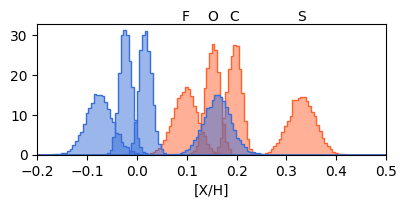

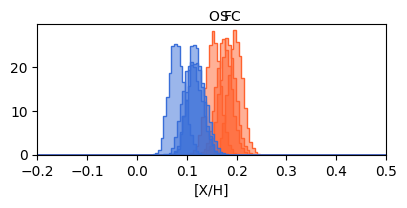

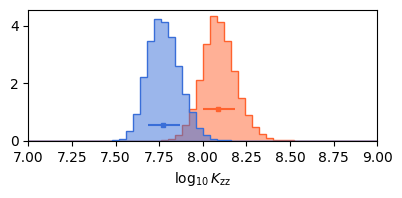

In [12]:
bins = 130; hist_range = [-0.2,0.5]
fig, ax = plt.subplots(figsize=(4.5,1.7))
ax.hist(abs_abund_A['C/H'], bins=bins, range=hist_range, **hist_kwargs_A); ax.annotate('C', xy=(np.median(abs_abund_A['C/H']), 1.0), xycoords=ax.get_xaxis_transform(), ha='center', va='bottom')
ax.hist(abs_abund_A['O/H'], bins=bins, range=hist_range, **hist_kwargs_A); ax.annotate('O', xy=(np.median(abs_abund_A['O/H']), 1.0), xycoords=ax.get_xaxis_transform(), ha='center', va='bottom')
# ax.hist(abs_abund_A['N/H'], bins=bins, range=hist_range, **hist_kwargs_A); ax.annotate('N', xy=(np.median(abs_abund_A['N/H']), 0.9), xycoords=ax.get_xaxis_transform(), ha='center', va='center')
ax.hist(abs_abund_A['S/H'], bins=bins, range=hist_range, **hist_kwargs_A); ax.annotate('S', xy=(np.median(abs_abund_A['S/H']), 1.0), xycoords=ax.get_xaxis_transform(), ha='center', va='bottom')
ax.hist(abs_abund_A['F/H'], bins=bins, range=hist_range, **hist_kwargs_A); ax.annotate('F', xy=(np.median(abs_abund_A['F/H']), 1.0), xycoords=ax.get_xaxis_transform(), ha='center', va='bottom')

ax.hist(abs_abund_B['C/H'], bins=bins, range=hist_range, **hist_kwargs_B)
ax.hist(abs_abund_B['O/H'], bins=bins, range=hist_range, **hist_kwargs_B)
# ax.hist(abs_abund_B['N/H'], bins=bins, range=hist_range, **hist_kwargs_B)
ax.hist(abs_abund_B['S/H'], bins=bins, range=hist_range, **hist_kwargs_B)
ax.hist(abs_abund_B['F/H'], bins=bins, range=hist_range, **hist_kwargs_B)

ax.set(xlim=hist_range, xlabel='[X/H]')
plt.show()

fig, ax = plt.subplots(figsize=(4.5,1.7))
ax.hist(abs_abund_A_eq['C/H'], bins=bins, range=hist_range, **hist_kwargs_A); ax.annotate('C', xy=(np.median(abs_abund_A_eq['C/H']), 1.0), xycoords=ax.get_xaxis_transform(), ha='center', va='bottom')
ax.hist(abs_abund_A_eq['O/H'], bins=bins, range=hist_range, **hist_kwargs_A); ax.annotate('O', xy=(np.median(abs_abund_A_eq['O/H']), 1.0), xycoords=ax.get_xaxis_transform(), ha='center', va='bottom')
# ax.hist(abs_abund_A_eq['N/H'], bins=bins, range=hist_range, **hist_kwargs_A); ax.annotate('N', xy=(np.median(abs_abund_A_eq['N/H']), 0.9), xycoords=ax.get_xaxis_transform(), ha='center', va='center')
ax.hist(abs_abund_A_eq['S/H'], bins=bins, range=hist_range, **hist_kwargs_A); ax.annotate('S', xy=(np.median(abs_abund_A_eq['S/H']), 1.0), xycoords=ax.get_xaxis_transform(), ha='center', va='bottom')
ax.hist(abs_abund_A_eq['F/H'], bins=bins, range=hist_range, **hist_kwargs_A); ax.annotate('F', xy=(np.median(abs_abund_A_eq['F/H']), 1.0), xycoords=ax.get_xaxis_transform(), ha='center', va='bottom')

ax.hist(abs_abund_B_eq['C/H'], bins=bins, range=hist_range, **hist_kwargs_B)
ax.hist(abs_abund_B_eq['O/H'], bins=bins, range=hist_range, **hist_kwargs_B)
# ax.hist(abs_abund_B_eq['N/H'], bins=bins, range=hist_range, **hist_kwargs_B)
ax.hist(abs_abund_B_eq['S/H'], bins=bins, range=hist_range, **hist_kwargs_B)
ax.hist(abs_abund_B_eq['F/H'], bins=bins, range=hist_range, **hist_kwargs_B)

ax.set(xlim=hist_range, xlabel='[X/H]')
plt.show()

log_Kzz_A_eq = A_eq.posterior[:,A_eq.ParamTable.get('log_Kzz_chem', key='idx_free')]
log_Kzz_B_eq = B_eq.posterior[:,B_eq.ParamTable.get('log_Kzz_chem', key='idx_free')]
# print('log_Kzz_chem:'); result_utils.latex_format(log_Kzz_A_eq, log_Kzz_B_eq, decimals=2)

bins = 50; hist_range = [7.0,9.0]
fig, ax = plt.subplots(figsize=(4.5,1.7))
ax.hist(log_Kzz_A_eq, label='A', bins=bins, range=hist_range, **hist_kwargs_A_eq)
ax.hist(log_Kzz_B_eq, label='B', bins=bins, range=hist_range, **hist_kwargs_B_eq)
# ax.hist(chem_ratios_A[key], label='A', bins=bins, range=hist_range, **hist_kwargs_A)
plot_errorbar(ax, log_Kzz_A_eq, y=0.24, q=result_utils.q[[2,4]], color=color_A)
plot_errorbar(ax, log_Kzz_B_eq, y=0.12, q=result_utils.q[[2,4]], color=color_B)
ax.set(xlim=hist_range, xlabel=r'$\log_{10} K_\mathrm{zz}$')
plt.show()

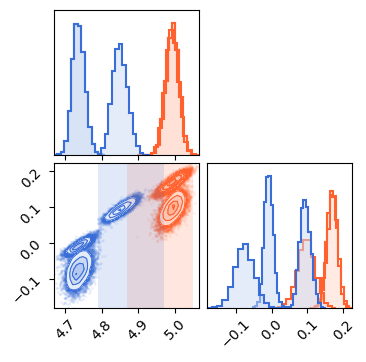

In [13]:
def get_log_g_posterior(Res):
    # Load the ParamTable module
    Res.load_components(['ParamTable'])
    
    # Get the indices of the free parameters
    idx_free = Res.ParamTable.get('log_g', key='idx_free')
    return Res.posterior[:,idx_free]

log_g_A = get_log_g_posterior(A)
log_g_B = get_log_g_posterior(B)
log_g_A_eq = get_log_g_posterior(A_eq)
log_g_B_eq = get_log_g_posterior(B_eq)

corner_kwargs = dict(
    bins=15, 
    #range=posterior_ranges, 
    
    fill_contours=True, 
    plot_datapoints=True, 
    
    #labels=labels, 
    #show_titles=True, 
    use_math_text=True, 
    title_fmt='.2f', 
    title_kwargs={'fontsize':10},#, 'loc':'left', 'x':0.05}, 
    #labelpad=0.03, 
    labelpad=-0.03, 
    
    #smooth=True, 
)
fig = plt.figure(figsize=(4,4))

corner_kwargs['color'] = color_A
corner_kwargs['hist_kwargs'] = {
    'edgecolor':color_A, 'facecolor':env_colors_A[1], 'fill':True, 'density':True, 'lw':1.5, 
    }
corner_kwargs['contourf_kwargs'] = {'colors':env_colors_A}
corner_kwargs['contour_kwargs']  = {'linewidths':0.8, 'colors':color_A}
fig = corner.corner(fig=fig, data=np.array([log_g_A, abs_abund_A['(C+O)/H']]).T, **corner_kwargs)
fig = corner.corner(fig=fig, data=np.array([log_g_A, abs_abund_A['F/H']]).T, **corner_kwargs)

corner_kwargs['hist_kwargs']['fill'] = False
fig = corner.corner(fig=fig, data=np.array([log_g_A_eq, abs_abund_A_eq['(C+O)/H']]).T, **corner_kwargs)

corner_kwargs['color'] = color_B
corner_kwargs['hist_kwargs'] = {
    'edgecolor':color_B, 'facecolor':env_colors_B[1], 'fill':True, 'density':True, 'lw':1.5, 
    }
corner_kwargs['contourf_kwargs'] = {'colors':env_colors_B}
corner_kwargs['contour_kwargs']  = {'linewidths':0.8, 'colors':color_B}
fig = corner.corner(fig=fig, data=np.array([log_g_B, abs_abund_B['(C+O)/H']]).T, **corner_kwargs)
fig = corner.corner(fig=fig, data=np.array([log_g_B, abs_abund_B['F/H']]).T, **corner_kwargs)

corner_kwargs['contourf_kwargs'] = {'colors':env_colors_B*np.array([1,1,1,0.])}
fig = corner.corner(fig=fig, data=np.array([log_g_B_eq, abs_abund_B_eq['(C+O)/H']]).T, **corner_kwargs)

ax = fig.axes[2]
ax.axvspan(4.96-0.09, 4.96+0.09, color=color_A, lw=0, alpha=0.15)
ax.axvspan(4.88-0.09, 4.88+0.09, color=color_B, lw=0, alpha=0.15)
plt.show()

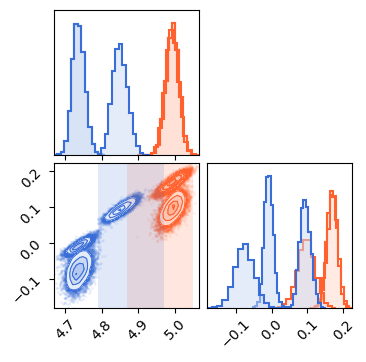

In [14]:
def get_log_g_posterior(Res):
    # Load the ParamTable module
    Res.load_components(['ParamTable'])
    
    # Get the indices of the free parameters
    idx_free = Res.ParamTable.get('log_g', key='idx_free')
    return Res.posterior[:,idx_free]

log_g_A = get_log_g_posterior(A)
log_g_B = get_log_g_posterior(B)
log_g_A_eq = get_log_g_posterior(A_eq)
log_g_B_eq = get_log_g_posterior(B_eq)

corner_kwargs = dict(
    bins=15, 
    #range=posterior_ranges, 
    
    fill_contours=True, 
    plot_datapoints=True, 
    
    #labels=labels, 
    #show_titles=True, 
    use_math_text=True, 
    title_fmt='.2f', 
    title_kwargs={'fontsize':10},#, 'loc':'left', 'x':0.05}, 
    #labelpad=0.03, 
    labelpad=-0.03, 
    
    #smooth=True, 
)
fig = plt.figure(figsize=(4,4))

corner_kwargs['color'] = color_A
corner_kwargs['hist_kwargs'] = {
    'edgecolor':color_A, 'facecolor':env_colors_A[1], 'fill':True, 'density':True, 'lw':1.5, 
    }
corner_kwargs['contourf_kwargs'] = {'colors':env_colors_A}
corner_kwargs['contour_kwargs']  = {'linewidths':0.8, 'colors':color_A}
fig = corner.corner(fig=fig, data=np.array([log_g_A, abs_abund_A['(C+O)/H']]).T, **corner_kwargs)
fig = corner.corner(fig=fig, data=np.array([log_g_A, abs_abund_A['F/H']]).T, **corner_kwargs)

corner_kwargs['hist_kwargs']['fill'] = False
fig = corner.corner(fig=fig, data=np.array([log_g_A_eq, abs_abund_A_eq['(C+O)/H']]).T, **corner_kwargs)

corner_kwargs['color'] = color_B
corner_kwargs['hist_kwargs'] = {
    'edgecolor':color_B, 'facecolor':env_colors_B[1], 'fill':True, 'density':True, 'lw':1.5, 
    }
corner_kwargs['contourf_kwargs'] = {'colors':env_colors_B}
corner_kwargs['contour_kwargs']  = {'linewidths':0.8, 'colors':color_B}
fig = corner.corner(fig=fig, data=np.array([log_g_B, abs_abund_B['(C+O)/H']]).T, **corner_kwargs)
fig = corner.corner(fig=fig, data=np.array([log_g_B, abs_abund_B['F/H']]).T, **corner_kwargs)

corner_kwargs['contourf_kwargs'] = {'colors':env_colors_B*np.array([1,1,1,0.])}
fig = corner.corner(fig=fig, data=np.array([log_g_B_eq, abs_abund_B_eq['(C+O)/H']]).T, **corner_kwargs)

ax = fig.axes[2]
ax.axvspan(4.96-0.09, 4.96+0.09, color=color_A, lw=0, alpha=0.15)
ax.axvspan(4.88-0.09, 4.88+0.09, color=color_B, lw=0, alpha=0.15)
plt.show()

In [15]:
log_g_A_J = get_log_g_posterior(A_J)
log_g_B_J = get_log_g_posterior(B_J)

In [16]:
from tqdm import tqdm
import copy

A_eq.load_components(['PT'])
B_eq.load_components(['PT'])

# Turn off the quenching
# A_eq.Chem['K2166_1'].quench_VMRs = lambda *args, **kwargs: None
# B_eq.Chem['K2166_1'].quench_VMRs = lambda *args, **kwargs: None

Chem_A_eq_wo_quenching = copy.deepcopy(A_eq.Chem['K2166_1'])
Chem_B_eq_wo_quenching = copy.deepcopy(B_eq.Chem['K2166_1'])

idx_A = list(np.random.randint(0, A_eq.posterior.shape[0], size=1000))
idx_B = list(np.random.randint(0, B_eq.posterior.shape[0], size=1000))

Chem_A_eq_wo_quenching.quench_settings_posterior = {key: [] for key in Chem_A_eq_wo_quenching.quench_settings.keys()}
Chem_B_eq_wo_quenching.quench_settings_posterior = {key: [] for key in Chem_B_eq_wo_quenching.quench_settings.keys()}
Chem_A_eq_wo_quenching.VMRs_posterior = {species: [] for species in Chem_A_eq_wo_quenching.VMRs.keys()}
Chem_B_eq_wo_quenching.VMRs_posterior = {species: [] for species in Chem_B_eq_wo_quenching.VMRs.keys()}

for i, sample in enumerate(tqdm(A_eq.posterior[idx_A], desc='A_eq')):
    # Update the parameters
    A_eq.ParamTable.set_apply_prior(False)
    A_eq.ParamTable(cube=sample)
    A_eq.ParamTable.set_apply_prior(True)

    # Calculate the VMRs
    Chem_A_eq_wo_quenching(A_eq.ParamTable, A_eq.PT['K2166_1'].temperature_posterior[idx_A][i])
    for species in Chem_A_eq_wo_quenching.VMRs_posterior.keys():
        Chem_A_eq_wo_quenching.VMRs_posterior[species].append(Chem_A_eq_wo_quenching.VMRs[species])

    for key, value in Chem_A_eq_wo_quenching.quench_settings.items():
        Chem_A_eq_wo_quenching.quench_settings_posterior[key].append(value[-1])
        
for i, sample in enumerate(tqdm(B_eq.posterior[idx_B], desc='B_eq')):
    # Update the parameters
    B_eq.ParamTable.set_apply_prior(False)
    B_eq.ParamTable(cube=sample)
    B_eq.ParamTable.set_apply_prior(True)

    # Calculate the VMRs
    Chem_B_eq_wo_quenching(B_eq.ParamTable, B_eq.PT['K2166_1'].temperature_posterior[idx_B][i])
    for species in Chem_B_eq_wo_quenching.VMRs_posterior.keys():
        Chem_B_eq_wo_quenching.VMRs_posterior[species].append(Chem_B_eq_wo_quenching.VMRs[species])

    for key, value in Chem_B_eq_wo_quenching.quench_settings.items():
        Chem_B_eq_wo_quenching.quench_settings_posterior[key].append(value[-1])

# Convert the lists to numpy arrays
for key in Chem_A_eq_wo_quenching.quench_settings_posterior.keys():
    Chem_A_eq_wo_quenching.quench_settings_posterior[key] = np.array(Chem_A_eq_wo_quenching.quench_settings_posterior[key])
    Chem_B_eq_wo_quenching.quench_settings_posterior[key] = np.array(Chem_B_eq_wo_quenching.quench_settings_posterior[key])

B_eq: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.46it/s]


/var/tmp/regt/ipykernel_533962/845636739.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  ax.errorbar(


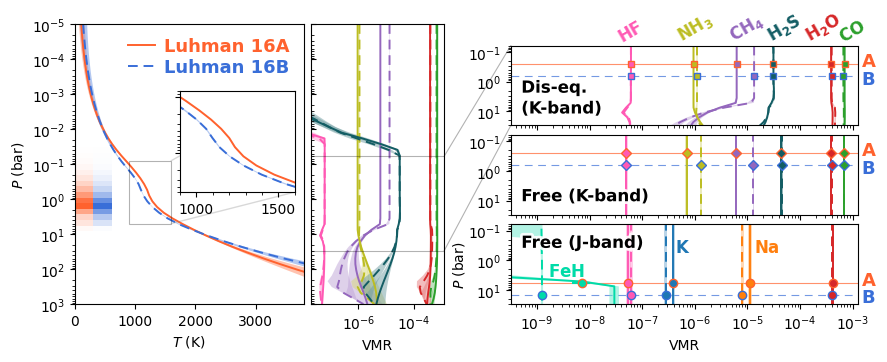

In [25]:
A.load_components(['PT']); B.load_components(['PT'])
A_eq.load_components(['PT']); B_eq.load_components(['PT'])
A_J.load_components(['PT']); B_J.load_components(['PT'])

y_A = 10**(np.log10(0.4)-0.2)
y_B = 10**(np.log10(0.4)+0.2)

# xlim_VMR = (10**(-7.7), 10**(-2.8))
xlim_VMR = (10**(-9.5), 10**(-2.9))
ylim_VMR = (30,0.06)

fig = plt.figure(figsize=(9,3.5))
gs = fig.add_gridspec(
    # ncols=3, nrows=5, hspace=0.15, wspace=0.05, width_ratios=[0.3,0.35,0.35], height_ratios=[0.2,1,1,1,0.2], 
    ncols=5, nrows=4, hspace=0.15, wspace=0.05, width_ratios=[0.05,0.25,0.18,0.07,0.47], height_ratios=[0.15,1,1,1], 
    )

ax_contr = fig.add_subplot(gs[:,0])
ax_PT = fig.add_subplot(gs[:,:2])
ax_VMR = fig.add_subplot(gs[:,2])

ax_eq = fig.add_subplot(gs[1,-1])
ax_fc = fig.add_subplot(gs[2,-1])
ax_J = fig.add_subplot(gs[3,-1])

# --- PT profiles --------------------------------------
ax_contr.imshow(
    contr_A_eq['K2166_1'].reshape(-1,1), cmap=cmap_A, aspect='auto', interpolation='none', 
    extent=[0,0.5,0,1], transform=ax_contr.transAxes, 
)
ax_contr.imshow(
    contr_B_eq['K2166_1'].reshape(-1,1), cmap=cmap_B, aspect='auto', interpolation='none', 
    extent=[0.5,1,0,1], transform=ax_contr.transAxes, 
)
ax_contr.set_axis_off()
ax_contr.set(yticks=[], xticks=[])

# --- PT profiles --------------------------------------
ax_ins = ax_PT.inset_axes(
    bounds=(0.46,0.40,0.50,0.36), transform=ax_PT.transAxes, #xlim=(1000,1500), ylim=(1e1,1e-1), 
)
ax_ins.set_xticks([900,1100,1200,1300,1400,1500,1600], minor=True)
ax_ins.set_xticks([1000,1500])
ax_ins.set(yscale='log', xlim=(900,1600), ylim=(5e0,8e-2), yticklabels=[])
ax_PT.indicate_inset_zoom(ax_ins, ec='k', lw=0.8, alpha=0.3)
# ax_ins = None

for ax_i in [ax_PT, ax_ins]:
    if ax_i is None:
        continue
    temperature_q = result_utils.profile_quantiles(A_eq.PT['K2166_1'].temperature_posterior)
    plot_envelopes(
        ax_i, A_eq.Chem['K2166_1'].pressure, temperature_q, median_kwargs=dict(c=color_A, lw=1.4), 
        **dict(fc=env_colors_A[3:], ec='none', alpha=0.5), x_indices=[[2,4]]
        )
    temperature_q = result_utils.profile_quantiles(B_eq.PT['K2166_1'].temperature_posterior)
    plot_envelopes(
        ax_i, B_eq.Chem['K2166_1'].pressure, temperature_q, median_kwargs=dict(c=color_B, lw=1.4, ls=(0,(5,3))), 
        **dict(fc=env_colors_B[3:], ec='none', alpha=0.5), x_indices=[[2,4]]
        )
    
    # if ax_i is ax_PT:
    #     continue
    
    # temperature_q = result_utils.profile_quantiles(A.PT['K2166_1'].temperature_posterior)
    # plot_envelopes(
    #     ax_i, A.Chem['K2166_1'].pressure, temperature_q, median_kwargs=dict(c=color_A, lw=1.4, ls=':'), 
    #     **dict(fc=env_colors_A[3:], ec='none', alpha=0.5), x_indices=[[2,4]]
    #     )
    # temperature_q = result_utils.profile_quantiles(B.PT['K2166_1'].temperature_posterior)
    # plot_envelopes(
    #     ax_i, B.Chem['K2166_1'].pressure, temperature_q, median_kwargs=dict(c=color_B, lw=1.4, ls=':'), 
    #     **dict(fc=env_colors_B[3:], ec='none', alpha=0.5), x_indices=[[2,4]]
    #     )
    
handle_A, = ax_PT.plot(np.nan, np.nan, color=color_A, lw=1.4, label='Luhman 16A')
handle_B, = ax_PT.plot(np.nan, np.nan, color=color_B, lw=1.4, ls=(0,(5,3)), label='Luhman 16B')
ax_PT.legend(
    loc='upper right', bbox_to_anchor=(0.97,0.98), frameon=False, 
    handlelength=1.5, handletextpad=0.5, labelspacing=0.2, borderaxespad=0.0, 
    labelcolor='linecolor', prop={'weight':'bold', 'size':13}, 
)
ax_PT.set(
    xlim=(0,3800), xlabel=r'$T$ (K)', #xticks=[0,1000,2000,3000],
    yscale='log', ylim=(1e3, 1e-5), facecolor='none', ylabel=r'$P$ (bar)',
)

# --- VMR profiles -------------------------------------
species_info = {
    '12CO': ('C2', 'CO', (+0.15,0)), 
    'H2O': ('C3', 'H_2O', (-0.15,0)),
    'CH4': ('C4', 'CH_4', (0,0)),
    'NH3': ('C8', 'NH_3', (0,0)),
    'H2S': ('#135D64', 'H_2S', (+0.2,0)),
    'HF': ('#FF59B4', 'HF', (0,0)),
}
for species, (c, l, xy) in species_info.items():
    l = r'$\mathrm{\bf '+f'{l}'+'}$'
    fc = mpl.colors.LinearSegmentedColormap.from_list('', ['w',c])([0.6,0.8,1.0])

    log_g_norm_factor = 10**(4.96-log_g_A_eq)
    plot_VMR_envelope(
        ax_VMR, A_eq.Chem['K2166_1'], species, log_g_norm_factor=log_g_norm_factor[:,None], 
        median_kwargs=dict(c=c, lw=1.4, ls='-'), **dict(fc=fc, ec='none', alpha=0.5)
        )
    log_g_norm_factor = 10**(4.88-log_g_B_eq)
    plot_VMR_envelope(
        ax_VMR, B_eq.Chem['K2166_1'], species, log_g_norm_factor=log_g_norm_factor[:,None], 
        median_kwargs=dict(c=c, lw=1.4, ls=(0,(5,3))), **dict(fc=fc, ec='none', alpha=0.5)
        )

    x = np.mean([np.median(abs_abund_A_eq[species]), np.median(abs_abund_B_eq[species])])
    x = 10**(np.log10(x)+xy[0])
    y = 1 + xy[1]
    ax_eq.annotate(
        l, xy=(x,y), xycoords=ax_eq.get_xaxis_transform(), ha='center', va='bottom', fontsize=12, c=c, rotation=30, 
        )
    
ax_VMR.tick_params(axis='y', which='both', direction='in')
ax_VMR.set(
    xscale='log', xlim=(10**(-7.7),xlim_VMR[1]), xlabel='VMR', yscale='log', ylim=(1e3, 1e-5), yticklabels=[], 
    )

# --- VMR at photosphere -------------------------------
for i, ax_i in enumerate([ax_eq, ax_fc, ax_J]):
    ax_i.set(yscale='log', ylim=ylim_VMR)
    ax_i.set(xscale='log', xlim=xlim_VMR, xlabel='VMR')
    if i != 2:
        ax_i.set_xticklabels([])
        # ax_i.set_yticklabels([])
        ax_i.set_xlabel('')
    else:
        ax_i.set_ylabel(r'$P$ (bar)', labelpad=1)

    # ax_i.set_yticks([1e1,1e0,1e-1]); ax_i.set_yticklabels([r'$10$', r'$1$', r'$0.1$'])
    ax_i.set_yticks([1e1,1e0,1e-1]); ax_i.set_yticklabels([r'$10^1$', r'$10^0$', r'$10^{-1}$'])

ann_kwargs = dict(
    xycoords='axes fraction', fontsize=12, c='k', fontweight='bold',
    path_effects=[pe.withStroke(linewidth=4, foreground='w', alpha=0.9)],
)
ax_eq.annotate('Dis-eq.\n(K-band)', ha='left', va='bottom', xy=(0.03,0.1), **ann_kwargs)
ax_fc.annotate('Free (K-band)', ha='left', va='bottom', xy=(0.03,0.12), **ann_kwargs)
ax_J.annotate('Free (J-band)', ha='left', va='top', xy=(0.03,0.88), **ann_kwargs)

from matplotlib.patches import ConnectionPatch
kwargs = dict(coordsA=ax_VMR.get_yaxis_transform(), coordsB=ax_eq.get_yaxis_transform(), color='k', lw=0.8, alpha=0.3)
con = ConnectionPatch(xyA=(1, ylim_VMR[1]), xyB=(0, ylim_VMR[1]), **kwargs); ax_VMR.add_artist(con)
con = ConnectionPatch(xyA=(1, ylim_VMR[0]), xyB=(0, ylim_VMR[0]), **kwargs); ax_VMR.add_artist(con)
# ax_VMR.plot([1, 1], [1e-1, 15], transform=ax_VMR.get_yaxis_transform(), lw=1.6, c='k', clip_on=False)
ax_VMR.plot([0,1,1,0], [ylim_VMR[1],ylim_VMR[1],ylim_VMR[0],ylim_VMR[0]], transform=ax_VMR.get_yaxis_transform(), color='k', lw=0.8, alpha=0.3)

for species, (c, l, xy) in species_info.items():
    fc = mpl.colors.LinearSegmentedColormap.from_list('', ['w',c])([0.6,0.8,1.0])

    log_g_norm_factor = 10**(4.96-log_g_A_eq)
    plot_VMR_envelope(
        ax_eq, A_eq.Chem['K2166_1'], species, log_g_norm_factor=log_g_norm_factor[:,None], 
        median_kwargs=dict(c=c, lw=1.4, ls='-'), **dict(fc=fc, ec='none', alpha=0.5), 
        )
    plot_errorbar(
        ax_eq, abs_abund_A_eq[species]*log_g_norm_factor, y=y_A, q=result_utils.q[[2,4]], color=c, transform=ax_eq.transData, ms=5, mec=color_A
        )

    log_g_norm_factor = 10**(4.96-log_g_A)
    plot_VMR_envelope(
        ax_fc, A.Chem['K2166_1'], species, log_g_norm_factor=log_g_norm_factor[:,None], 
        median_kwargs=dict(c=c, lw=1.4, ls='-'), **dict(fc=fc, ec='none', alpha=0.5)
        )
    plot_errorbar(
        ax_fc, abs_abund_A[species]*log_g_norm_factor, y=y_A, q=result_utils.q[[2,4]], color=c, transform=ax_fc.transData, marker='D', ms=5, mec=color_A
        )
    
    log_g_norm_factor = 10**(4.88-log_g_B_eq)
    plot_VMR_envelope(
        ax_eq, B_eq.Chem['K2166_1'], species, log_g_norm_factor=log_g_norm_factor[:,None], 
        median_kwargs=dict(c=c, lw=1.4, ls=(0,(5,3))), **dict(fc=fc, ec='none', alpha=0.5)
        )
    plot_errorbar(
        ax_eq, abs_abund_B_eq[species]*log_g_norm_factor, y=y_B, q=result_utils.q[[2,4]], color=c, transform=ax_eq.transData, ms=5, mec=color_B
        )

    log_g_norm_factor = 10**(4.88-log_g_B)
    plot_VMR_envelope(
        ax_fc, B.Chem['K2166_1'], species, log_g_norm_factor=log_g_norm_factor[:,None], 
        median_kwargs=dict(c=c, lw=1.4, ls=(0,(5,3))), **dict(fc=fc, ec='none', alpha=0.5)
        )
    plot_errorbar(
        ax_fc, abs_abund_B[species]*log_g_norm_factor, y=y_B, q=result_utils.q[[2,4]], color=c, transform=ax_fc.transData, marker='D', ms=5, mec=color_B
        )
    
species_info = {
    'H2O': ('C3', 'H_2O', (-0.2,0)),
    'HF': ('#FF59B4', 'HF', (0,-0.44)),
    'Na': ('C1', 'Na', (0,0)), 
    'K': ('C0', 'K', (0,0)),
    'FeH': ('#00DBA8', 'FeH', (0,0)),
}
for species, (c, l, xy) in species_info.items():
    fc = mpl.colors.LinearSegmentedColormap.from_list('', ['w',c])([0.6,0.8,1.0])

    log_g_norm_factor = 10**(4.96-log_g_A_J)
    plot_VMR_envelope(
        ax_J, A_J.Chem['J1226_1'], species, log_g_norm_factor=log_g_norm_factor[:,None], 
        median_kwargs=dict(c=c, lw=1.4, ls='-'), **dict(fc=fc, ec='none', alpha=0.5)
        )
    plot_errorbar(
        ax_J, abs_abund_A_J[species]*log_g_norm_factor, y=10**(np.log10(9.)-0.2), q=result_utils.q[[2,4]], color=c, transform=ax_J.transData, marker='o', ms=6, mec=color_A
        )
        
    log_g_norm_factor = 10**(4.88-log_g_B_J)
    plot_VMR_envelope(
        ax_J, B_J.Chem['J1226_1'], species, log_g_norm_factor=log_g_norm_factor[:,None], 
        median_kwargs=dict(c=c, lw=1.4, ls=(0,(5,3))), **dict(fc=fc, ec='none', alpha=0.5)
        )
    plot_errorbar(
        ax_J, abs_abund_B_J[species]*log_g_norm_factor, y=10**(np.log10(9.)+0.2), q=result_utils.q[[2,4]], color=c, transform=ax_J.transData, marker='o', ms=6, mec=color_B
        )

ax_J.annotate(
    r'$\mathrm{\bf FeH}$', xy=(10**(-8.45),0.3), xycoords=ax_J.get_xaxis_transform(), 
    ha='center', va='bottom', fontsize=12, c=species_info['FeH'][0], rotation=0, 
    )
ax_J.annotate(
    r'$\mathrm{\bf K}$', xy=(10**(-6.23),0.6), xycoords=ax_J.get_xaxis_transform(), 
    ha='center', va='bottom', fontsize=12, c=species_info['K'][0], rotation=0, 
    )
ax_J.annotate(
    r'$\mathrm{\bf Na}$', xy=(10**(-4.62),0.6), xycoords=ax_J.get_xaxis_transform(), 
    ha='center', va='bottom', fontsize=12, c=species_info['Na'][0], rotation=0, 
    )

for ax_i, y_cen in zip([ax_eq, ax_fc, ax_J], [0.4,0.4,9]):
    ax_i.annotate(
        r'$\mathrm{\bf A}$', xy=(1.01, 10**(np.log10(y_cen)-0.3)), xycoords=ax_i.get_yaxis_transform(), 
        ha='left', va='center', fontsize=13, c=color_A,
        )
    ax_i.annotate(
        r'$\mathrm{\bf B}$', xy=(1.01, 10**(np.log10(y_cen)+0.3)), xycoords=ax_i.get_yaxis_transform(), 
        ha='left', va='center', fontsize=13, c=color_B,
        )
    
    kwargs = dict(lw=0.8, c=color_A, zorder=-1, alpha=0.7)
    ax_i.plot([0.,1.0], [10**(np.log10(y_cen)-0.2)]*2, transform=ax_i.get_yaxis_transform(), **kwargs)
    kwargs['ls'] = (0,(7,5)); kwargs['c'] = color_B
    ax_i.plot([0.,1.0], [10**(np.log10(y_cen)+0.2)]*2, transform=ax_i.get_yaxis_transform(), **kwargs)

plt.subplots_adjust(left=0.09, bottom=0.15, top=0.95, right=0.96)
plt.savefig('./plots/K_band_VMR_profiles.pdf')
plt.show()

## log(g) - metallicity degeneracy

In [ ]:
def get_log_g_posterior(Res):
    # Load the ParamTable module
    Res.load_components(['ParamTable'])
    
    # Get the indices of the free parameters
    idx_free = Res.ParamTable.get('log_g', key='idx_free')
    return Res.posterior[:,idx_free]

log_g_A = get_log_g_posterior(A)
log_g_B = get_log_g_posterior(B)
log_g_A_eq = get_log_g_posterior(A_eq)
log_g_B_eq = get_log_g_posterior(B_eq)

In [ ]:
corner_kwargs = dict(
    bins=15, 
    #range=posterior_ranges, 
    
    fill_contours=True, 
    plot_datapoints=True, 
    
    #labels=labels, 
    #show_titles=True, 
    use_math_text=True, 
    title_fmt='.2f', 
    title_kwargs={'fontsize':10},#, 'loc':'left', 'x':0.05}, 
    #labelpad=0.03, 
    labelpad=-0.03, 
    
    #smooth=True, 
)
fig = plt.figure(figsize=(4,4))

corner_kwargs['color'] = color_A
corner_kwargs['hist_kwargs'] = {
    'edgecolor':color_A, 'facecolor':env_colors_A[1], 'fill':True, 'density':True, 'lw':1.5, 
    }
corner_kwargs['contourf_kwargs'] = {'colors':env_colors_A}
corner_kwargs['contour_kwargs']  = {'linewidths':0.8, 'colors':color_A}
fig = corner.corner(
    fig=fig, data=np.array([log_g_A, abs_abund_A['(C+O)/H']]).T, **corner_kwargs,
    # range=[(4.65,4.95),(-0.05,0.15),(-0.05,0.15),(-0.05,0.15)],
    )
# corner_kwargs['hist_kwargs']['fill'] = False
# fig = corner.corner(
#     fig=fig, data=np.array([log_g_A_eq, abs_abund_A_eq['(C+O)/H']]).T, **corner_kwargs,
#     # range=[(4.65,4.95),(-0.05,0.15),(-0.05,0.15),(-0.05,0.15)],
#     )

corner_kwargs['color'] = color_B
corner_kwargs['hist_kwargs'] = {
    'edgecolor':color_B, 'facecolor':env_colors_B[1], 'fill':True, 'density':True, 'lw':1.5, 
    }
corner_kwargs['contourf_kwargs'] = {'colors':env_colors_B}
corner_kwargs['contour_kwargs']  = {'linewidths':0.8, 'colors':color_B}
fig = corner.corner(
    fig=fig, data=np.array([log_g_B, abs_abund_B['(C+O)/H']]).T, **corner_kwargs,
    #range=[(4.65,4.95),(-0.05,0.12),(-0.05,0.12),(-0.05,0.12)],
    )

# corner_kwargs['contourf_kwargs'] = {'colors':env_colors_B*np.array([1,1,1,0.])}
# fig = corner.corner(
#     fig=fig, data=np.array([log_g_B_eq, abs_abund_B_eq['(C+O)/H']]).T, **corner_kwargs,
#     )
plt.show()